# Lab session 2: Fast Wavelet Transform, image compression and denoising

Name(s): Dard Anthony, Roussel Léon 

## Prerequisite

### Install Anaconda and PyWavelet

* The simplest is to download the Anaconda distribution (including PyWavelet) : https://www.anaconda.com/ 
* Or follows these instructions: https://pywavelets.readthedocs.io/en/latest/install.html
* Read the documentation on Pywavelet: https://pywavelets.readthedocs.io/_/downloads/en/v0.5.1/pdf/
* Code available on Github (to know how it is implemented): https://github.com/PyWavelets/pywt/tree/580d79d9440ec0f4f936892e39c79ad13a8fd33b 

### Instructions

* Fill empty codes and answer the questions in the notebook
* Upload on TEIDE an archive (with your NAME in capital letters, separated by an underscore for teams NAME1_NAME2) containing:
    * your completed notebook (the python code .ipynb)
    * the corresponding exported PDF
* **Deadline: December 18 (23h59)**. 

### Mark scheme

* This practical work is graded out of 20 points (but at the end the two lab sessions will represent a quarter of the final mark, i.e each accounting for 2,5 points)
* Hand in overdue: -10% per day
* Plagiarism (e.g copy/paste codes of others students): mark divided by 2

### Packages

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from numpy import random

## The 1-D Discrete Wavelet Transform

### Play with the DWT of simple 1-D signals

Let's start with the toy example used in the course (*slides 180-182*):

In [14]:
vals = [2, 4, 8, 12, 14, 0, 2, 1]

**Question 1** *(1 point)*. Plot the corresponding piecewise constant function on a uniform grid on $[0,1]$ as in the course (pay attention to the interval limits). 

*Hint: you can use the command* `plt.step`

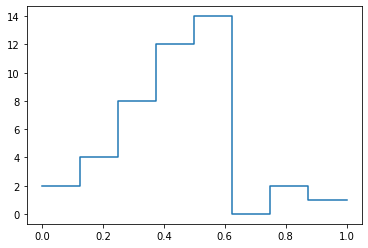

In [15]:
x = np.linspace(0, 1, len(vals) + 1)
plt.step(x, vals + [1], where='post')

**Question 2** *(1 point)*. Compute the 1-D discrete wavelet transform with `pywt.dwt` and the Haar wavelet (see documentation: https://pywavelets.readthedocs.io/en/latest/regression/dwt-idwt.html). Show that to a factor we retrieve the approximation and details coefficients found in the course.

In [16]:
cA, cD = pywt.dwt(vals, wavelet='haar')
print(cA / np.sqrt(2.0))
print(cD / np.sqrt(2.0))

[ 3.  10.   7.   1.5]
[-1.  -2.   7.   0.5]


We effectively get the correct coefficients.

**Question 3** *(2 points)*. Show numerically that it is equivalent to perform a convolution with filters $h=[1,1]/\sqrt{2}$ and $g=[-1,1]/\sqrt{2}$ respectively followed by a decimation. Write the complete decomposition by iterating the procedure on the approximation coefficients (by applying the convolutions or directly `pywt.dwt`).

In [17]:
h = np.array([1, 1]) / np.sqrt(2.0)
g = np.array([-1, 1]) / np.sqrt(2.0)

# iteration 1:
print("Only one step :")
print(np.convolve(vals, h, mode='same')[1::2])
print(np.convolve(vals, g, mode='same')[1::2])
print()

# iteration 1:
cD3 = np.convolve(vals, g, mode='same')[1::2]
temp = np.convolve(vals, h, mode='same')[1::2]
# iteration 2:
cD2 = np.convolve(temp, g, mode='same')[1::2]
temp = np.convolve(temp, h, mode='same')[1::2]
# iteration 3:
cD1 = np.convolve(temp, g, mode='same')[1::2]
cA = np.convolve(temp, h, mode='same')[1::2]

print("approx :", cA)
print("details :", cD1, cD2, cD3)

Only one step :
[ 4.24264069 14.14213562  9.89949494  2.12132034]
[-1.41421356 -2.82842712  9.89949494  0.70710678]

approx : [15.2027958]
details : [3.18198052] [-7.   5.5] [-1.41421356 -2.82842712  9.89949494  0.70710678]


**We found the same results than the previous question to a factor \sqrt(2) with only one iteration.**

### 1-D Multi-resolution analysis with the Haar wavelet

**Question 4** *(2 points)*. Obtain the same results by computing the multi-resolution analysis of `vals` with `pywt.wavedec`, the Haar wavelet and the option `mode='zero'` (see documentation: https://pywavelets.readthedocs.io/en/latest/regression/multilevel.html and https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#modes)  

In [18]:
c = pywt.wavedec(vals, 'haar', mode='zero')
print("approx:", c[0])
print("details:", *c[1:])

approx: [15.2027958]
details: [3.18198052] [-7.   5.5] [-1.41421356 -2.82842712  9.89949494  0.70710678]


**This is the same results.**

**Question 5** *(2 points)*. Apply the same decomposition to the `Piece-Regular` signal `f`. Plot the projections of `f` on different approximation and detail spaces as illustrated in the course (*slide 184*).

In [19]:
# Recover manually (without dwt/idwt)
def decode(approx, details):
    decoded = []
    for i in range(len(approx)):
        decoded += [(approx[i] + details[i]) / np.sqrt(2.0)]
        decoded += [(approx[i] - details[i]) / np.sqrt(2.0)]
    return decoded

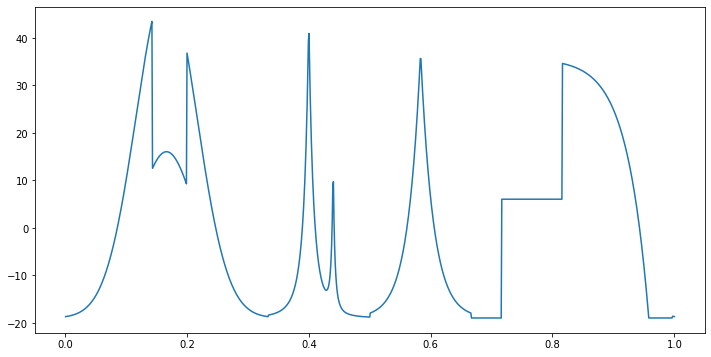

In [20]:
n = 1024
f = pywt.data.demo_signal('Piece-Regular', n)
t = np.arange(1, n + 1)/n
plt.figure(figsize=(12, 6))
plt.plot(t, f)
plt.show()

Text(0.5, 1.0, 'Details')

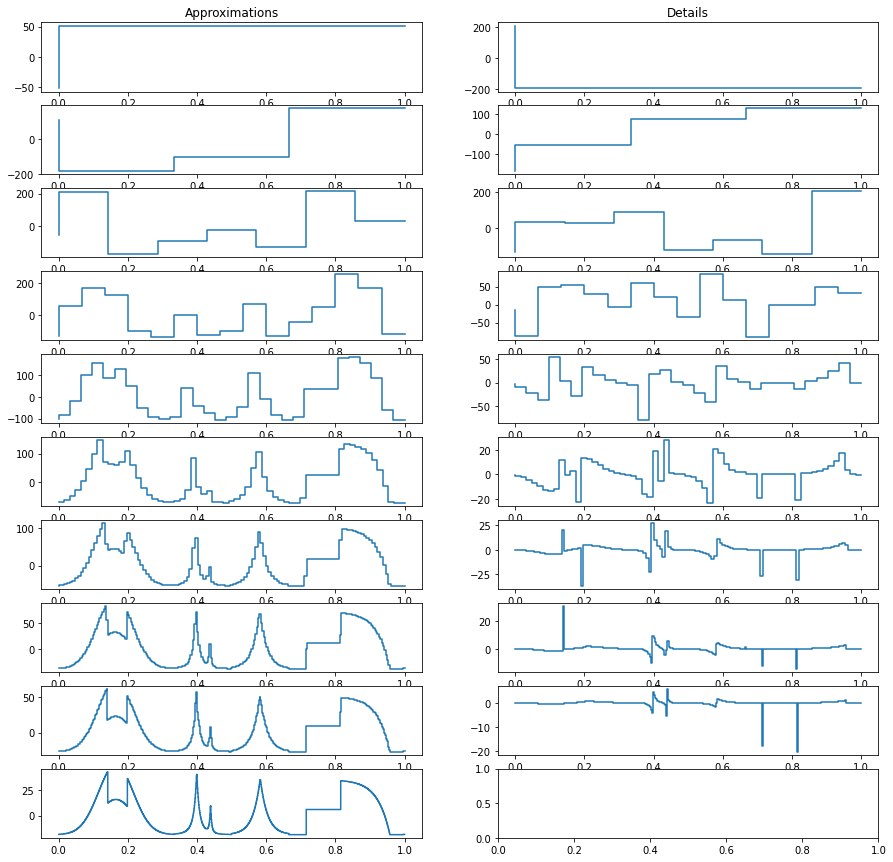

In [21]:
c = pywt.wavedec(f, 'haar', mode='zero')

fig, axs = plt.subplots(nrows=len(c)-1, ncols=2, figsize=(15, 15))

decoded = c[0]
for i in range(len(c)-1):
    decoded = decode(decoded, c[i+1])
    x = np.linspace(0, 1, len(decoded))
    axs[i][0].step(x, decoded)
    if i +2 < len(c):
        x = np.linspace(0, 1, len(c[i+2]))
        axs[i][1].step(x, c[i+2])

axs[0][0].set_title("Approximations")
axs[0][1].set_title("Details")

### 1-D Multi-resolution analysis with the Debauchies wavelets

In [22]:
w = pywt.Wavelet('db2')
print(w)

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


The filters used to construct the corresponding scaling and wavelet functions are given by:

In [23]:
fb = w.filter_bank
print(fb)

([-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416], [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037], [0.48296291314453416, 0.8365163037378079, 0.2241438680420134, -0.12940952255126037], [-0.12940952255126037, -0.2241438680420134, 0.8365163037378079, -0.48296291314453416])


*Remark*. The low-pass and high-pass filters of the decomposition are respectively denoted by `dec_lo` and `dec_hi`, as well for the reconstruction filter `rec_lo` and `rec_hi`, hence `filter_bank = (dec_lo, dec_hi, rec_lo, rec_li)`. Since this wavelet is of type orthogonal, then the reconstruction filters $h$ (low-pass) and $g$ (high-pass) are the flipped version of the decomposition filters $\check g$ and $\check h$:

In [24]:
(w.dec_lo == w.rec_lo[::-1]) & (w.dec_hi == w.rec_hi[::-1])

True

One can plot these filters:

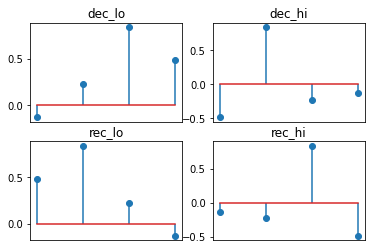

In [25]:
filt_type = ["dec_lo", "dec_hi", "rec_lo", "rec_hi"]
for index in range(4):
    ax = plt.subplot(2, 2, index + 1)
    plt.stem(range(4), fb[index], use_line_collection = True)
    plt.title(filt_type[index])
    ax.axes.get_xaxis().set_visible(False)
plt.show()

As well for the corresponding scaling and wavelet functions:

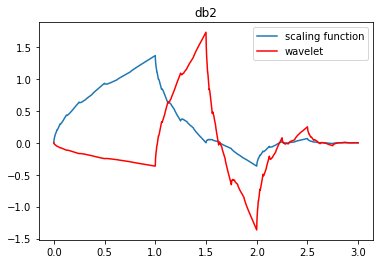

In [26]:
(phi, psi, x) = w.wavefun(level=10)
plt.plot(x, phi, label = "scaling function")
plt.plot(x, psi, 'r', label = "wavelet")
plt.legend()
plt.title(w.name)
plt.show()

Please visit: http://wavelets.pybytes.com/wavelet/db2/ for a more complete overview. 

**Question 6** *(2 points)*. Visualize the results obtained by replacing in Question 5 `'Haar'` by `'db2'`. *(This reproduces the figures in the course at slides 209-210)*

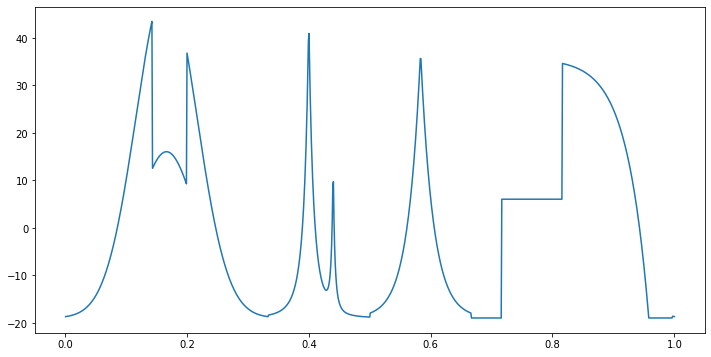

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(t, f)
plt.show()

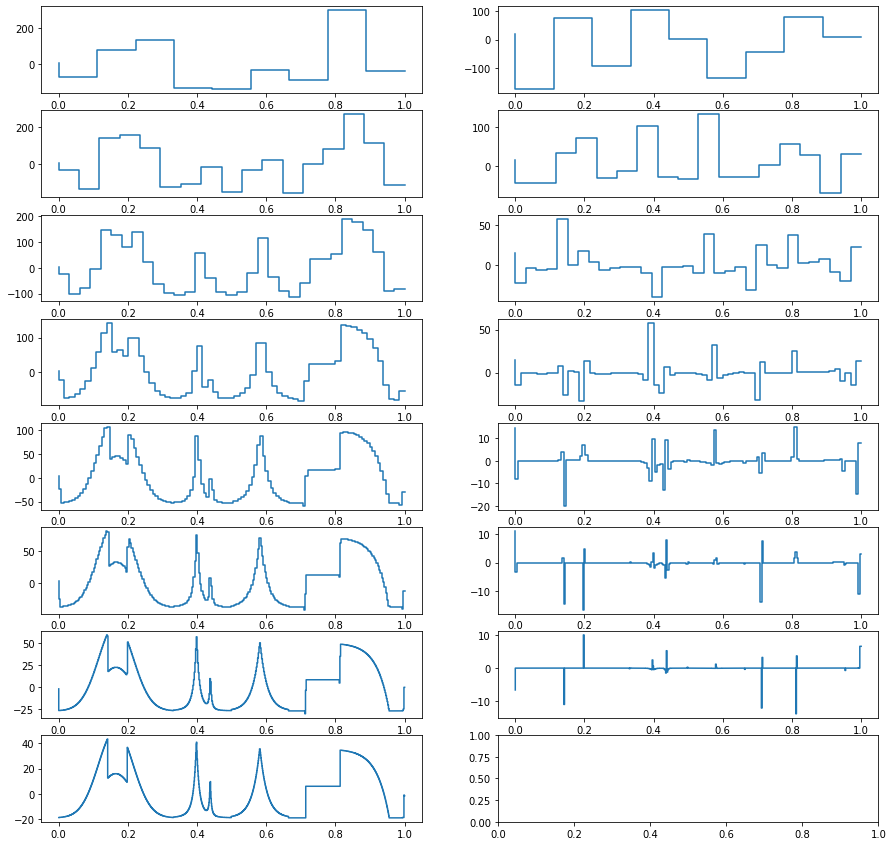

In [28]:
c = pywt.wavedec(f, 'db2', mode='zero')

fig, axs = plt.subplots(nrows=len(c)-1, ncols=2, figsize=(15, 15))

decoded = c[0]
c[-1] = np.concatenate((c[-1], [c[-1][-1]]))

for i in range(len(c)-1):
    decoded = pywt.idwt(decoded, c[i+1], wavelet="db2")
    x = np.linspace(0, 1, len(decoded))
    axs[i][0].step(x, decoded)
    if i + 2 < len(c):
        x = np.linspace(0, 1, len(c[i+2]))
        axs[i][1].step(x, c[i+2])

### Signal compression and reconstruction

**Question 7** *(3 points)*. Write two functions:
* `compression` which keeps the $M$ largest coefficients of a wavelet decomposition and put the others to zero.
* `reconstruction` which reconstruct the signal $\tilde f_M$ from the $M$ largest coefficients with `pywt.waverec` and compute the $L_2$ relative error with the original signal $f$, that is $\epsilon(M)=\frac{\|f-\tilde f_M\|_2}{\|f\|_2}$

*Hint:* You might need the following commands: 
* `np.ravel` (see doc: https://numpy.org/doc/stable/reference/generated/numpy.ravel.html)
* `pywt.coeffs_to_array` and `pywt.array_to_coeffs` (see doc: https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html)

Then apply `compression` and `reconstruction` to the `Piece-regular` function with the Daubechies wavelet `db2` and the following parameters:

In [67]:
def compression(signal, M, wavelet):
    # Return the coeffs decomposition with only the M biggest values
    c = pywt.wavedec(signal, wavelet=wavelet, mode="zero")
    flatten, slices = pywt.coeffs_to_array(c)

    s = np.argsort(np.abs(flatten[1:])) + 1 # give indices in increasing order in absolute value !
    for i in s[:-M]:
        flatten[i] = 0.0 # set to 0 everything but the M bigger elements

    return pywt.array_to_coeffs(flatten, slices, output_format='wavedec')

def reconstruction(coeffs, wavelet):
    return pywt.waverec(coeffs, wavelet)

def L2error(original, compressed_recon):
    return np.linalg.norm(original - compressed_recon) / np.linalg.norm(original)

L2 relative error for db2 : 0.08204324963643764


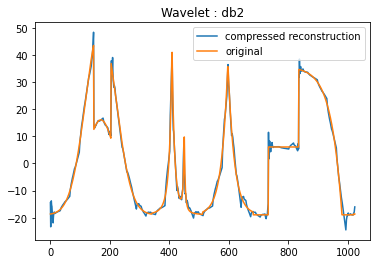

L2 relative error for haar : 0.09508122063128259


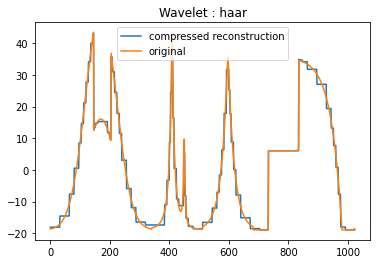

In [68]:
n = 1024
f = pywt.data.demo_signal('Piece-Regular', n)

#f = vals
#n = len(vals)

t = np.arange(1, n + 1)/n
ratio = 7.5/100
M = int(ratio * n)
compressFactor = 1 - ratio

# db2
w = 'db2'
compressed_coeffs = compression(f, M, wavelet=w)
recon = reconstruction(compressed_coeffs, wavelet=w)
print("L2 relative error for db2 :", L2error(f, recon))

plt.plot(recon, label="compressed reconstruction")
plt.plot(f, label="original")
plt.title("Wavelet : " + w)
plt.legend()
plt.show()

# haar
w = 'haar'
compressed_coeffs = compression(f, M, wavelet=w)
recon = reconstruction(compressed_coeffs, wavelet=w)
print("L2 relative error for haar :", L2error(f, recon))

plt.plot(recon, label="compressed reconstruction")
plt.plot(f, label="original")
plt.title("Wavelet : " + w)
plt.legend()
plt.show()


**(Bonus)** *(1 point)* Same question with the function $x\mapsto \sqrt{|\cos(2\pi x)|}$ *(slide 212)* but now for different compression factors: plot the curve of the error $M\mapsto\epsilon(M)$ in the log-log scale using `plt.loglog`. What do you observe? Conclude.

In [31]:
from sklearn.linear_model import LinearRegression

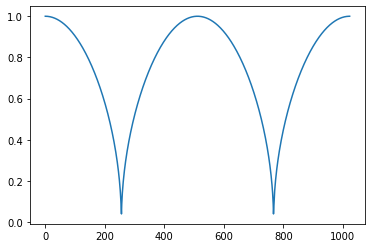

slope: -0.035198522787635994 intercept: 0.023741864940837985


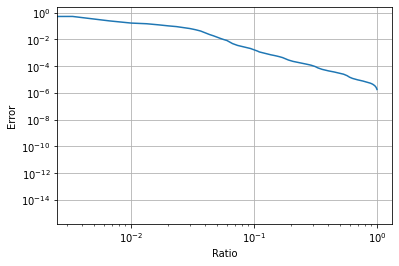

In [34]:
n = 1024
f = np.sqrt(np.abs(np.cos(2 * np.pi * np.linspace(0, 1, n))))
plt.plot(f)
plt.show()

#f = pywt.data.demo_signal('Piece-Regular', n)

t = np.arange(1, n + 1)/n
w = 'db2'

ratio = np.linspace(0, 100, 300) / 100
error = []

for r in ratio:
  M = int(r * n)
  compressed_coeffs = compression(f, M, wavelet=w)
  recon = reconstruction(compressed_coeffs, wavelet=w)
  e =  L2error(f, recon)
  error.append(e)


plt.loglog(ratio, error)

reg = LinearRegression().fit(np.reshape(ratio, (-1, 1)), np.reshape(error, (-1, 1)))
print("slope:", reg.coef_[0][0], "intercept:", reg.intercept_[0])

plt.ylabel("Error")
plt.xlabel("Ratio")
plt.grid()
plt.show()

**Commentary : ...**

## 2-D Discrete Wavelet Transform

### 2-D Multi-resolution analysis

Now we will perform a 2-D MRA onto images and use their decomposition to compress and denoise them.

(-0.5, 511.5, 511.5, -0.5)

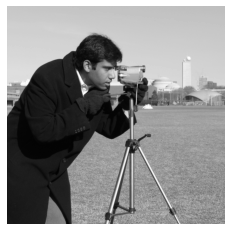

In [35]:
f = pywt.data.camera()
n = f.shape[0] # size of the image
plt.imshow(f, cmap='gray')
plt.axis('off')

The documentation of PyWavelet clearly explains below how to compute the 2-D multi-scale analysis (source: https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html):

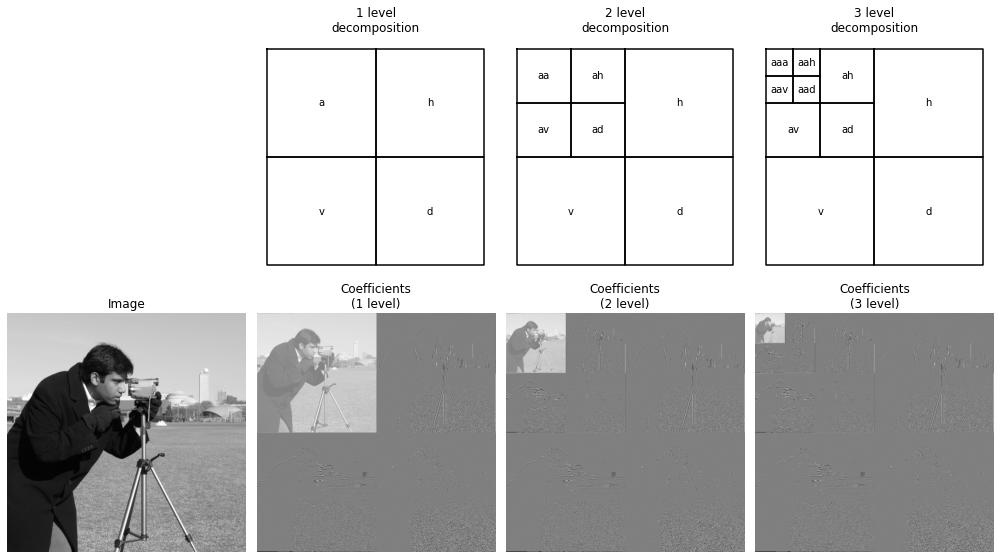

In [36]:
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x = pywt.data.camera().astype(np.float32)
shape = x.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c = pywt.wavedec2(x, 'db2', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

*Remark*. The notation is quite different from that of the course, in which the initial image is denoted by $C_9$ (since the size is $n=2^9=512$) and the indices of the coarser spaces decrease as follows *(notation `Dj_i` corresponds to $D_j^i$ in slide 215)*:

In [25]:
C6, (D6_2, D6_1, D6_3), (D7_2, D7_1, D7_3), (D8_2, D8_1, D8_3) = c

For example, the finest horizontal details (on the bottom left in the aboved last image) correspond to coefficients $D_8^1$:

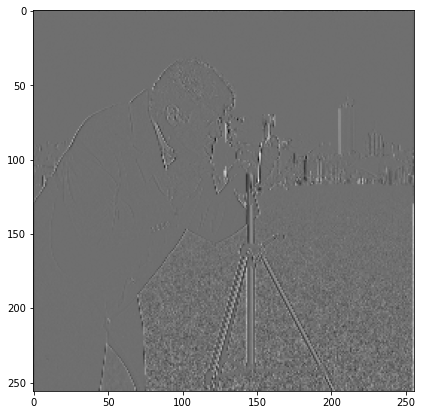

In [26]:
plt.figure(figsize=(7,7))
plt.imshow(D8_1, cmap=plt.cm.gray)
plt.show()

From these coefficients we are able to reconstruct the original image by `pywt.waverec2` (see documentation: https://pywavelets.readthedocs.io/en/latest/ref/nd-dwt-and-idwt.html#multilevel-reconstruction-waverecn)

### Image compression

**Question 8** *(2 points)*. Use the `compression` function which keeps the $M$ largest coefficients and reconstruct the compressed image with `pywt.waverec2`. Compute the PSNR with the original image and highlight the non-zeros coefficients in the multi-level decomposition plot.

In [123]:
def compression2d(signal, M, wavelet):
    # Return the coeffs decomposition with only the M biggest values
    c = pywt.wavedec2(signal, wavelet=wavelet, mode="zero")
    array, slices = pywt.coeffs_to_array(c)
    
    flatten = np.ravel(array)
    s = np.argsort(np.abs(flatten[1:])) + 1 # give indices in increasing order in absolute value !
    for i in s[:-M]:
        flatten[i] = 0.0 # set to 0 everything but the M bigger elements

    return pywt.array_to_coeffs(flatten.reshape(array.shape), slices, output_format='wavedec2')

def reconstruction2d(coeffs, wavelet):
    return pywt.waverec2(coeffs, wavelet)

In [124]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

In [125]:
ratio = 1.5 / 100
n = len(f)
M = int(ratio * n**2)
print("n:", n, "n^2:", n**2,"M:", M)
# compressFactor = 1 - ratio

img = pywt.data.camera().astype(np.float32)

n: 1024 n^2: 1048576 M: 15728


PSNR: 31.32178104179843


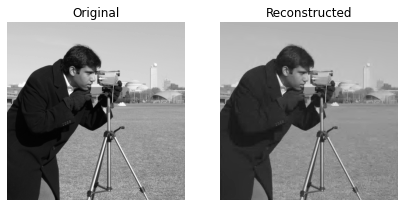

In [126]:
w = 'db2'
compressed_coeffs = compression2d(img, M, wavelet=w) 
recon = reconstruction2d(compressed_coeffs, wavelet=w)

# Plots
fig, axs = plt.subplots(1, 2, figsize=(7, 15))
axs[0].set_title("Original")
axs[0].imshow(img, cmap=plt.cm.gray)
axs[0].set_axis_off()

axs[1].set_title("Reconstructed")
axs[1].imshow(recon, cmap=plt.cm.gray)
axs[1].set_axis_off()

print("PSNR:", psnr(img, recon))

(array([379, 445, 445, ..., 130,  54, 518], dtype=int64), array([260, 261, 260, ...,  31,  99, 203], dtype=int64))


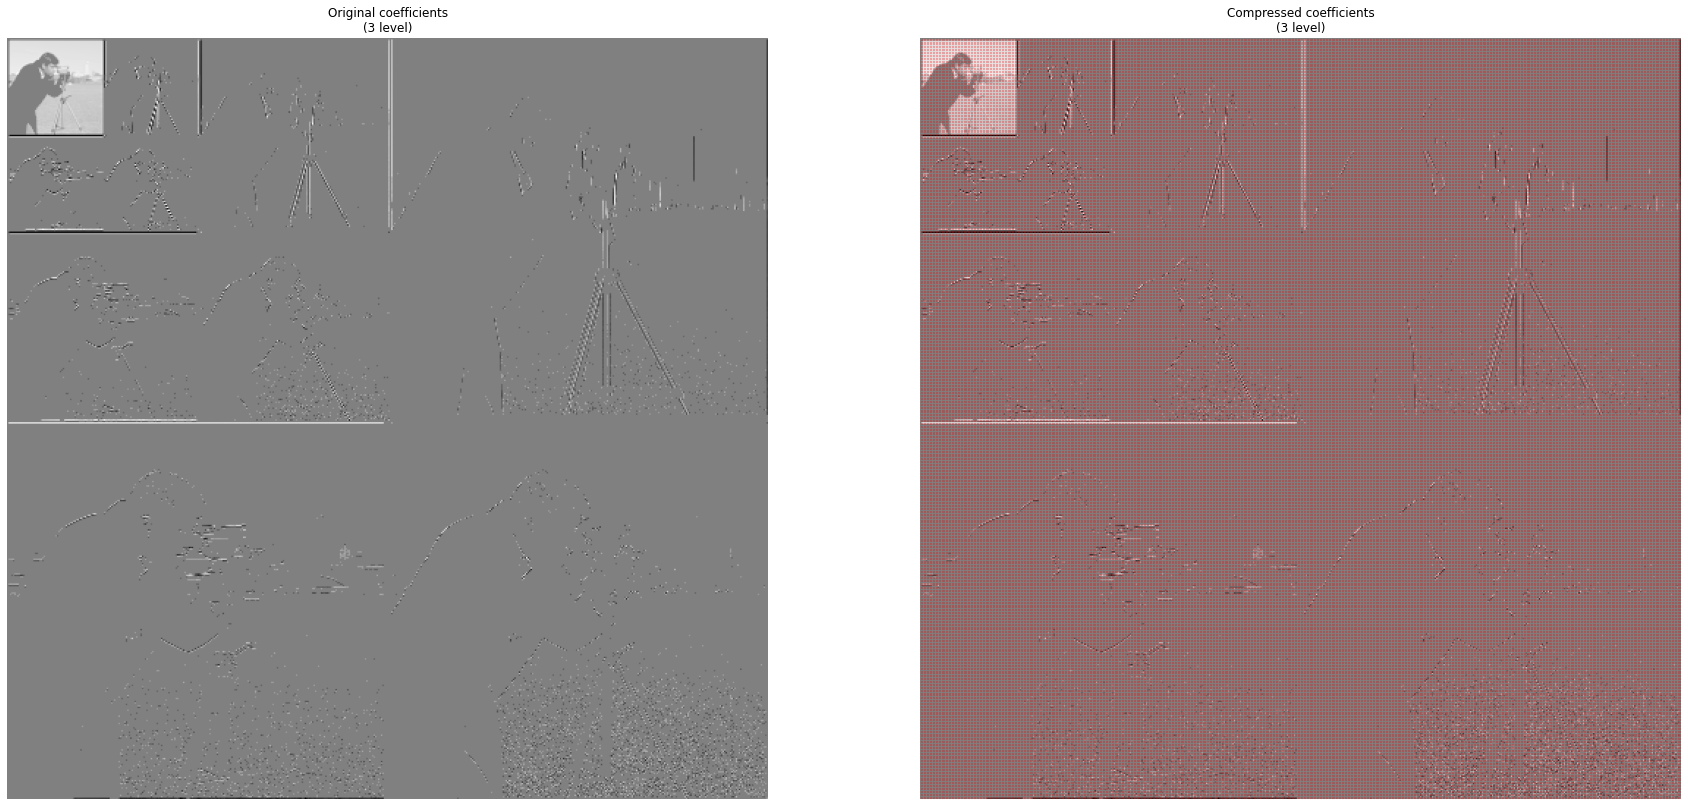

In [127]:
# Multilevel decomposition
level = 3
c = pywt.wavedec2(img, wavelet=w, mode="zero", level=level)
c[0] /= np.abs(c[0]).max()
for detail_level in range(level):
    c[detail_level + 1] = [d / np.abs(d).max() for d in c[detail_level + 1]]
arr, slices = pywt.coeffs_to_array(c)
flatten = np.ravel(arr)

s = np.argsort(np.abs(flatten[1:])) + 1 # give indices in increasing order in absolute value !
for i in s[:-M]:
    flatten[i] = 0.0 # set to 0 everything but the M bigger elements
compressed = flatten.reshape(arr.shape)

# Show coefs and highlights the zeroed coeffs
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
axs[0].set_title(f'Original coefficients\n({level} level)')
axs[0].set_axis_off()
axs[0].imshow(arr, cmap=plt.cm.gray)

axs[1].set_title(f'Compressed coefficients\n({level} level)')
axs[1].set_axis_off()
axs[1].imshow(compressed, cmap=plt.cm.gray)

zeroed = np.unravel_index(s, arr.shape)
print(zeroed)
axs[1].scatter(zeroed[1], zeroed[0], color='r', s=0.01)


### Image Denoising

**Question 9** *(2 points)*. Plot with `plt.semilogy` the decrease of the wavelet coefficients (sorted in absolute values) for the following image and its noisy version. (*hint: use the command `pywt.ravel_coeffs` see documentation https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html#raveling-and-unraveling-coefficients-to-from-a-1d-array*)

(-0.5, 511.5, 511.5, -0.5)

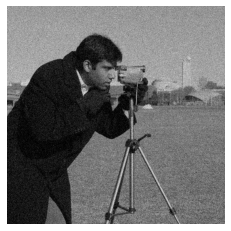

In [92]:
image = pywt.data.camera().astype(np.float32)
image = image / np.linalg.norm(image, 'fro') # normalization
wavelet = pywt.Wavelet('db4')
levels  = int(np.floor(np.log2(image.shape[0])))
sigma = 0.0003 # noise variance
imageNoisy = image + random.normal(0, sigma, size=image.shape)
plt.imshow(np.clip(imageNoisy,0,255), cmap='gray')
plt.axis('off')

Now we will apply a threshold to these coefficients in order to reduce the amount of noise. Two types of thresholding will be investigated:
* Hard thresholding
* Soft thresholding

It requires the use of the `pywt.threshold` command (see documentation: https://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html)

Text(0, 0.5, 'thresholded value')

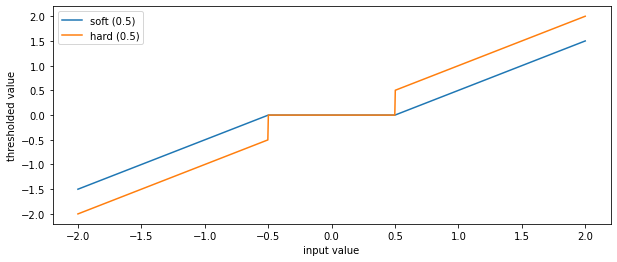

In [37]:
s = np.linspace(-2, 2, 1000)
s_soft = pywt.threshold(s, value = 0.5, mode = 'soft')
s_hard = pywt.threshold(s, value = 0.5, mode = 'hard')
plt.figure(figsize = (10, 4))
plt.plot(s, s_soft)
plt.plot(s, s_hard)
plt.legend(['soft (0.5)', 'hard (0.5)'])
plt.xlabel('input value')
plt.ylabel('thresholded value')

**Question 10** *(3 points)*. Write two functions which respectively denoise a 1-D signal and a 2-D image by applying a soft threshold $T$ on the wavelet coefficients, whose value is fixed to $T=\widehat \sigma \sqrt{2\log n}$. An estimator $\widehat \sigma$ of the true noise variance $\sigma$ (see variable `sigma`) is given by the median of the wavelet coefficients at the finest scale. Then, reconstruct the signal/image and plot the noisy et denoised version (on the same plot for signals and side-by-side for images). Experiment with `imageNoisy` (above) and `signalNoisy` (below) and try different wavelets (e.g `db4`).

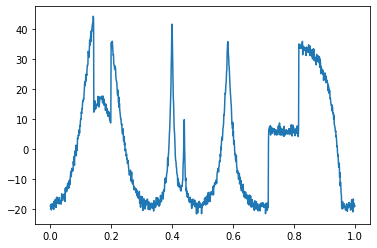

In [129]:
n = 1024
t = np.arange(1, n + 1) / n
signal = pywt.data.demo_signal('Piece-Regular', n)        # try also with 'Doppler'
sigma = 1                                                 # sigma = 0.03 for 'Doppler'            
signalNoisy = signal + sigma * random.standard_normal(n)
plt.plot(t, signalNoisy)
plt.show()

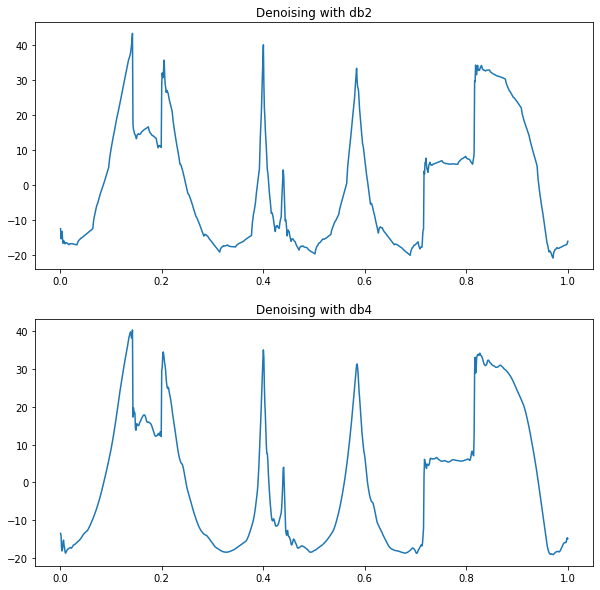

In [143]:

wavelets = ("db2", "db4")
fig, axs = plt.subplots(len(wavelets), figsize=(10, 10))

for i, w in enumerate(wavelets):
    c = pywt.wavedec(signalNoisy, wavelet=w, mode='zero')
    array, slices = pywt.coeffs_to_array(c)
    thresholded = pywt.threshold(array, value = sigma * np.sqrt(2 * np.log(n)), mode = 'soft')
    reconstructed = pywt.waverec(pywt.array_to_coeffs(thresholded, slices, "wavedec"), wavelet=w)

    axs[i].plot(t, reconstructed)
    axs[i].set_title(f"Denoising with {w} and soft threshold")